## 《合成孔径雷达成像——算法与实现》中3.5.1基带信号中的失配影响


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft,fftshift,ifft,ifftshift

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

In [49]:
#% 参数设置
TBP = 42;                #% 时间带宽乘积
T = 7.2e-6;              #% 脉冲持续时间
N_st = 2**11;                         
#% 参数计算
B = TBP/T;               #% 信号带宽
K = B/T;                 #% 调频频率
ratio = 200;             #% 过采样率，使用过高的过采样率是为了方便地实现升采样
F = ratio*B;             #% 采样频率
N = int(2*np.ceil(F*T/2));      # % 采样点数
dt = T/N;                #% 采样时间间隔
df = F/N;                #% 采样频率间隔
#% 参数设置
t_c = 0e-6;              #% 时间偏移
#% 参数计算
f_c = -K*t_c;            #% 中心频点
#% 变量设置
t1 = np.arange(-T/2,T/2,dt);     #% 时间变量
f1 = np.arange(-F/2,F/2,df);     #% 频率变量
#% 信号表达                             
st = np.exp(1j*np.pi*K*(t1-t_c)**2);          #% 发射信号
#% % 绘图
#% H1 = figure;
#% set(H1,'position',[100,100,600,300]);
# % subplot(211),plot(t1,real(st),'k')
# % subplot(212),plot(t1,imag(st),'k')
# % suptitle('发射信号')
# % 参数设置
t_0 = 10e-6;              #% 回波时延
# % 变量设置
t2 = np.arange(-T/2+t_0,T/2+t_0,dt);           # % 时间变量
f2 = np.arange(-F/2+f_c,F/2+f_c,df);           # % 频率变量
#% 信号表达                                                                 
srt = np.exp(1j*np.pi*K*(t2-t_c-t_0)**2);    # % 回波信号
Srf = fftshift(fft(srt));

In [50]:
#% 参数设置
QPE = np.linspace(0,0.8*np.pi,N);            #% 二次相位误差
dk = QPE/(np.pi*(T/2)**2);                # % 调频率误差
#% 参数设置
IRW1  = np.zeros(N);                    #% 初始化冲激响应宽度
PSLR1 = np.zeros(N);                    #% 初始化峰值旁瓣比
ISLR1 = np.zeros(N);                    #% 初始化积分旁瓣比
IRW2  = np.zeros(N);                    #% 初始化冲激响应宽度
PSLR2 = np.zeros(N);                    #% 初始化峰值旁瓣比
ISLR2 = np.zeros(N);                    #% 初始化积分旁瓣比
IRW3  = np.zeros(N);                    #% 初始化冲激响应宽度
PSLR3 = np.zeros(N);                    #% 初始化峰值旁瓣比
ISLR3 = np.zeros(N);                    #% 初始化积分旁瓣比


In [51]:
# 
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.signal import find_peaks
def pslr(Af):
    af = Af    
    #% 提取PSLR
    pks= find_peaks( af );
    sort_array = np.sort(af[pks[0]])[::-1]
#     PSLR = 20*np.log10( sort_array[0] )
    # 次峰
    PSLR = sort_array[1]  
    return PSLR
def irw(Af):
    #% 找到Af的最大位置
    locmax = np.argmax( Af );
    #% 找到locmax左边最接近-3dB的位置
    locleft = np.argmin(np.abs(Af[0:locmax]/np.max(np.abs(Af[0:locmax]))-0.707));
    #% 找到locmax右边最接近-3dB的位置
    locright = np.min(np.abs(Af[locmax+1:]/np.max(np.abs(Af[locmax+1:]))-0.707));
    locright = locright + locmax;
    #% 得到3dB波束宽度
    irw = locright-locleft
    return irw,locleft,locright

def  islr(af,Nr):      
#     #% 计算ISLR
    #% 找到Af的最大位置
    locmax = np.argmax( af );
    #% 找到locmax左边最接近-3dB的位置
    locleft = np.argmin(np.abs(af[0:locmax]/np.max(np.abs(af[0:locmax]))-0.707));
    #% 找到locmax右边最接近-3dB的位置
    locright = np.argmin(np.abs(af[locmax+1:]/np.max(np.abs(af[locmax+1:]))-0.707));
    locright = locright + locmax;
    #% 计算总功率
    P_total = np.sum(af[locleft-Nr:locright+Nr+1]**2);
    #% 计算主瓣功率
    P_main = np.sum(af[locleft:locright+1]**2);
    #% 一维积分旁瓣比
    ISLR = 10*np.log10((P_total-P_main)/P_main);
    return ISLR


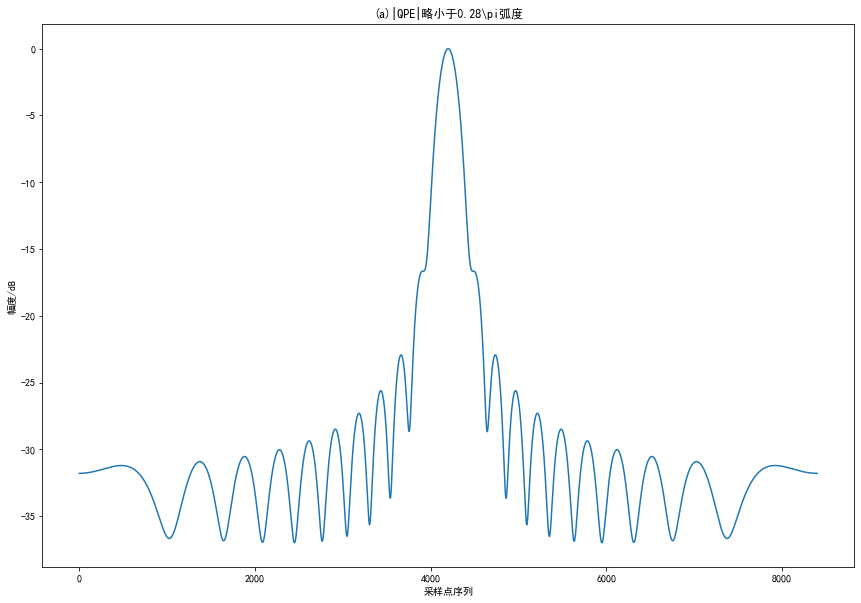

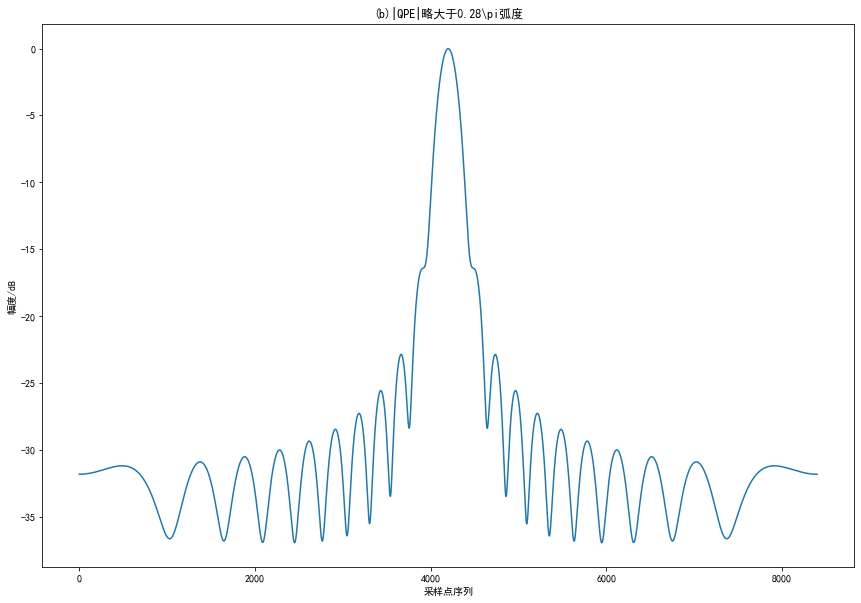

In [52]:
for i in range(N):
    #% 变量设置
    B_dk = (K+dk[i])*T;
    F_dk = ratio*B_dk;
    df_dk = F_dk/N;
    f3 = np.arange(-F_dk/2+f_c,F_dk/2+f_c,df_dk);          # % 频率变量
    #% 信号表达                                                                 
    st_dk = np.exp(1j*np.pi*(K+dk[i])*t1**2);                  
    Sf_dk = fftshift(fft(st_dk));
    #% 信号变换-->频域方式一
    window_1 = np.kaiser(N,2.5);                        # % 时域窗
    Window_1 = fftshift(window_1);                     #% 频域窗
    ht_dk_1 = np.conj(st_dk[::-1]);                  #   % 将时间反褶后的复制脉冲取复共轭
    ht_window_dk_1 = window_1*ht_dk_1;                #% 加窗
    Hf_dk_1 = fftshift(fft(ht_window_dk_1,N));         #% 计算补零离散傅里叶变换
    #% 信号变换-->频域方式二
    window_2 = np.kaiser(N,2.5);                         #% 时域窗
    Window_2 = fftshift(window_2);                     #% 频域窗
    ht_dk_2 = st_dk;                                   #% 复制信号
    ht_window_dk_2 = window_2*ht_dk_2;                #% 加窗
    Hf_dk_2 = fftshift(np.conj(fft(ht_window_dk_2,N)));   #% 计算补零离散傅里叶变换
    #% 信号变换-->频域方式三
    window_3 = np.kaiser(N,2.5);                        # % 时域窗
    Window_3 = fftshift(window_3);                     #% 频域窗
    Hf_dk_3 = Window_3*np.exp(1j*np.pi*f3**2/(K+dk[i]));    #% 计算补零离散傅里叶变换
#% 参数计算-->方式一                                         
    Soutf_dk_1 = Srf*Hf_dk_1;
    soutt_dk_1 = ifft(ifftshift(Soutf_dk_1));          #% 方式一匹配滤波结果 
    soutt_dk_1_nor = np.abs(soutt_dk_1)/np.max(np.abs(soutt_dk_1));               #% 归一化
    soutt_dk_1_log = 20*np.log10(np.abs(soutt_dk_1)/np.max(np.abs(soutt_dk_1))+np.finfo(np.float64).eps); #% 对数化
    #% 参数计算-->IRW
    irw_dk_1,locleft,locright= irw(fftshift(soutt_dk_1_nor));
    IRW1[i] = irw_dk_1;
    #% 参数计算-->PSLR
    pslr_dk_1 = pslr(fftshift(soutt_dk_1_log));
    PSLR1[i] = pslr_dk_1;
    #% 参数计算-->ISLR
    islr_dk_1 = islr(fftshift(soutt_dk_1_nor),5);
    ISLR1[i] = islr_dk_1;
    #% 绘图
    if i == 2990:
       plt.figure(figsize=(32,10));
       plt.subplot(121);plt.plot(fftshift(soutt_dk_1_log))
#        axis([3600 4800,-25 -15])
       plt.title('(a)|QPE|略小于0.28\pi弧度');plt.xlabel('采样点序列');plt.ylabel('幅度/dB')
    if i == 3100:
       plt.figure(figsize=(32,10));
       plt.subplot(122);plt.plot(fftshift(soutt_dk_1_log))
#        axis([3600 4800,-25 -15])
       plt.title('(b)|QPE|略大于0.28\pi弧度');plt.xlabel('采样点序列');plt.ylabel('幅度/dB')
#        suptitle('图3.15 最大旁瓣位置不同，而脉冲响应相似时的情况')

